In [154]:
from pathlib import Path

import numpy as np
import pandas as pd

DATA_DIR = Path("./pistachio_1_data")
df = pd.read_csv(DATA_DIR / "all_dyads.csv")

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_3946/2407243207.py:7: DtypeWarning: Columns (36,66,67,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_DIR / "all_dyads.csv")


In [155]:
import xgboost as xgb


def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df["therapy_length_days"] = (
        pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])
    ).dt.days

    df["day_of_week"] = pd.to_datetime(df["ActivityDateTime"]).dt.dayofweek
    df["hour"] = pd.to_datetime(df["ActivityDateTime"]).dt.hour

    # Select features
    df = df.drop(
        [
            "ActivityDateTime",
            "DurationInSeconds",  # total active time
            "SleepMorningDate",
            "Diagnosis",
            "CDI start date",
            "PDI start date",
            "PDI end date",
            # "Medication ",
            "Type of medication",
            "Medication start date",
            "Week",
            "Therapy session",
            "Therapy Start",
            "Therapy End",
            "Education Status",
            "Parental Status",
            "Pre.ECBI",
            "Pre.ECBI.Prob",
            "Post.ECBI",
            "Post.ECBI.Prob",
            "QuitStudy",
            "Employment Status",
            "ParticipatingParent.Sex",
            "Parent-PhoneType",
            # Data that is only available as "real time data" (more battery use?) in Companion SDK
            # NOTE: Removing these actually improves model accuracy?
            "DistanceInMeters",
            "ActiveKilocalories",
            "METmins",
            "METavg",
            "activity_seconds_sedentary",
            "activity_seconds_active",
            "activity_seconds_highly_active",
        ]
        # moving window stats
        + [
            "hr_moving_avg_15m",
            "hr_moving_std_15m",
            "hr_moving_min_15m",
            "hr_moving_max_15m",
            "hr_moving_avg_30m",
            "hr_moving_std_30m",
            "hr_moving_min_30m",
            "hr_moving_max_30m",
            "hr_moving_avg_45m",
            "hr_moving_std_45m",
            "hr_moving_min_45m",
            "hr_moving_max_45m",
        ],
        axis=1,
    )
    df = df.drop([col for col in df.columns if col.startswith("hr-prev")], axis=1)

    def yn_to_bool(df):
        """
        Convert columns with 'Y'/'N' strings to boolean True/False.
        """
        for col in df.columns:
            if df[col].nunique() == 2 and set(df[col].dropna().unique()) == {"Y", "N"}:
                df[col] = df[col].map({"Y": True, "N": False})
        return df

    df = yn_to_bool(df)

    # Convert categorical columns to dummy variables
    df = pd.get_dummies(df, drop_first=True)

    return df


def prep_X_y(df: pd.DataFrame, response_column: str) -> tuple[pd.DataFrame, pd.Series]:
    X = df.drop(
        [
            "tantrum_within_60m",
            "tantrum_within_45m",
            "tantrum_within_30m",
            "tantrum_within_15m",
            # Useful for indexing
            "Arm_Sham",
            "dyad",
        ],
        axis=1,
    )
    y = df[response_column].astype(int)
    return X, y

In [156]:
df = clean_data(df)

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_3946/1117677806.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])


In [157]:
df_train = df[df["Arm_Sham"]]
X_train, y_train = prep_X_y(df_train, "tantrum_within_60m")
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
base_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
base_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [158]:
from sklearn.metrics import f1_score, precision_score, recall_score

df_test = df[~df["Arm_Sham"]]
X_test, y_test = prep_X_y(df_test, "tantrum_within_60m")

y_pred = base_model.predict(X_test)


f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

F1 Score: 0.027101418589879314
Precision: 0.017062116768861636
Recall: 0.06584362139917696


In [159]:
from collections import defaultdict

from tqdm.auto import tqdm


def retrain_and_predict(df_train: pd.DataFrame, df: pd.DataFrame, mode: str):
    def train_model(df):
        X_train, y_train = prep_X_y(df, "tantrum_within_60m")
        scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
        model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
        model.fit(X_train, y_train)
        return model

    df["week"] = (df["therapy_length_days"] - df["therapy_length_days"].min()) // 7

    base_model = train_model(df_train)
    df_concat = df_train.copy()

    dyads = df["dyad"].unique()
    dyad_dfs = {dyad: df_train for dyad in dyads}
    dyad_models = {dyad: base_model for dyad in dyads}
    dyad_results = defaultdict(list)

    for week in tqdm(sorted(df["week"].unique())):
        week_df = df[df["week"] == week].drop("week", axis=1)

        for dyad, dyad_week_df in week_df.groupby("dyad"):
            X, y = prep_X_y(dyad_week_df, "tantrum_within_60m")

            model = dyad_models[dyad]
            y_pred = model.predict(X)

            f1 = f1_score(y, y_pred, zero_division=0)
            precision = precision_score(y, y_pred, zero_division=0)
            recall = recall_score(y, y_pred, zero_division=0)

            dyad_results[dyad].append(
                {"week": week, "f1": f1, "precision": precision, "recall": recall}
            )

        match mode:
            case "no_retrain":
                pass
            case "retrain_all":
                df_concat = pd.concat([df_concat, week_df])
                model = train_model(df_concat)
                for dyad in dyad_models.keys():
                    dyad_models[dyad] = model
            case "retrain_dyad":
                for dyad, dyad_week_df in week_df.groupby("dyad"):
                    for _ in range(len(dyads)):
                        boot_df = dyad_week_df.sample(
                            frac=1, replace=True, random_state=None
                        )
                        dyad_dfs[dyad] = pd.concat([dyad_dfs[dyad], boot_df])

                    model = train_model(dyad_dfs[dyad])
                    dyad_models[dyad] = model

    return dyad_results

In [160]:
no_retrain_results = retrain_and_predict(df_train, df, mode="no_retrain")

  0%|          | 0/57 [00:00<?, ?it/s]

In [162]:
retrain_all_results = retrain_and_predict(df_train, df, mode="retrain_all")

  0%|          | 0/57 [00:00<?, ?it/s]

In [161]:
retrain_dyad_results = retrain_and_predict(df_train, df, mode="retrain_dyad")

  0%|          | 0/57 [00:00<?, ?it/s]

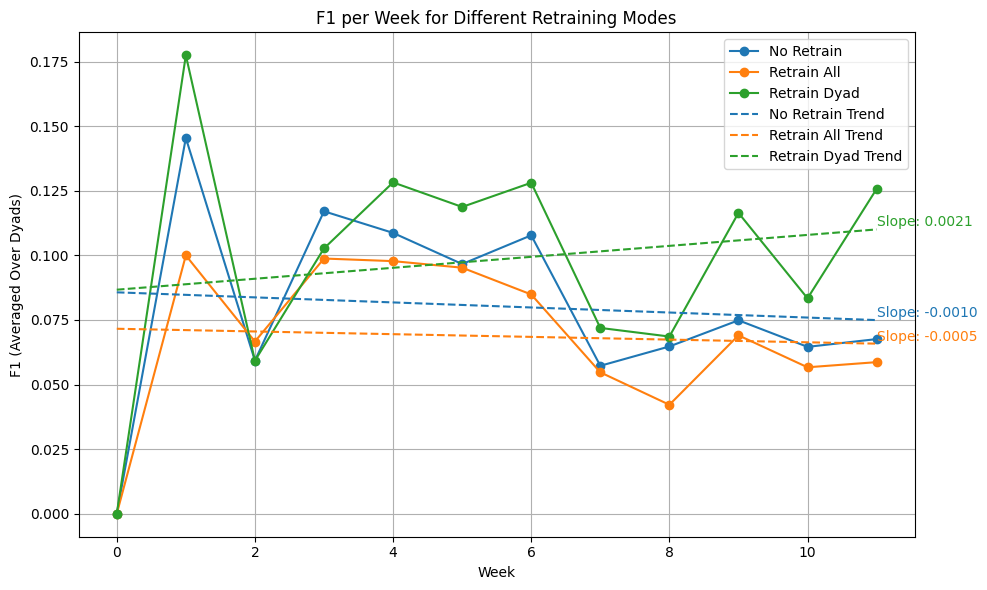

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import linregress


def get_weekly_metric(results, metric: str, week_cutoff: int):
    # results: dict of dyad -> list of dicts with 'week', 'recall', etc.
    week_metrics = {}
    for dyad, week_list in results.items():
        for entry in week_list:
            week = entry["week"]
            val = entry[metric]
            if week not in week_metrics:
                week_metrics[week] = []
            week_metrics[week].append(val)
    # Average over dyads for each week
    weeks = [w for w in sorted(week_metrics.keys()) if w < week_cutoff]
    avg_metrics = [np.mean(week_metrics[w]) for w in weeks]
    return weeks, avg_metrics


week_cutoff = 12
metric = "f1"

# Get weekly recall for each mode
weeks_nr, recalls_nr = get_weekly_metric(
    no_retrain_results, metric=metric, week_cutoff=week_cutoff
)
weeks_ra, recalls_ra = get_weekly_metric(
    retrain_all_results, metric=metric, week_cutoff=week_cutoff
)
weeks_rd, recalls_rd = get_weekly_metric(
    retrain_dyad_results, metric=metric, week_cutoff=week_cutoff
)

plt.figure(figsize=(10, 6))
plt.plot(weeks_nr, recalls_nr, label="No Retrain", marker="o")
plt.plot(weeks_ra, recalls_ra, label="Retrain All", marker="o")
plt.plot(weeks_rd, recalls_rd, label="Retrain Dyad", marker="o")

# Add trend lines
for weeks, recalls, label, color in [
    (weeks_nr, recalls_nr, "No Retrain Trend", "C0"),
    (weeks_ra, recalls_ra, "Retrain All Trend", "C1"),
    (weeks_rd, recalls_rd, "Retrain Dyad Trend", "C2"),
]:
    if len(weeks) > 1:
        slope, intercept, _, _, _ = linregress(weeks, recalls)
        trend = np.array(weeks) * slope + intercept
        plt.plot(weeks, trend, linestyle="--", color=color, label=label)
        plt.text(
            weeks[-1],
            trend[-1],
            f"Slope: {slope:.4f}",
            color=color,
            verticalalignment="bottom",
            fontsize=10,
        )

plt.xlabel("Week")
plt.ylabel(f"{metric.capitalize()} (Averaged Over Dyads)")
plt.title(f"{metric.capitalize()} per Week for Different Retraining Modes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

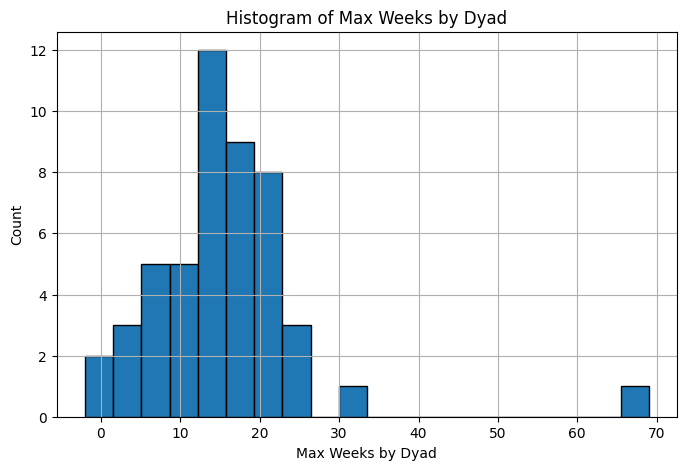

In [163]:
import matplotlib.pyplot as plt

# Compute max week per dyad
max_weeks_by_dyad = df.groupby("dyad")["therapy_length_days"].max() // 7

plt.figure(figsize=(8, 5))
plt.hist(max_weeks_by_dyad, bins=20, edgecolor="black")
plt.xlabel("Max Weeks by Dyad")
plt.ylabel("Count")
plt.title("Histogram of Max Weeks by Dyad")
plt.grid(True)
plt.show()